In [74]:
from tqdm import tqdm
import pickle
import gzip
from typing import List
import matplotlib.pyplot as plt

import numpy as np

from neural_network.layers.base_layer import BaseLayer
from neural_network.layers.linear_layer import LinearLayer
from neural_network.layers.relu_layer import ReluLayer
from neural_network.layers.sigmoid_layer import SigmoidLayer
from neural_network.models.layer_types import LayerTypes
from neural_network.utils import predict, accuracy

from neural_network.losses.squared_loss import SquaredLoss
from neural_network.losses.absolute_loss import AbsoluteLoss

import tensorflow as tf

In [75]:
# set the seed to zero for reproducibility
np.random.seed(0)

In [76]:
# input
input_size = 1024
# output
output_size = 1024

# number of samples (datapoints)
N_TRAIN = 1_000
N_TEST = 10

In [77]:
x_train = np.random.multivariate_normal(mean=np.zeros(shape=(input_size,)), cov=np.eye(input_size), size=N_TRAIN)

min_vals = np.min(x_train, axis=0)
max_vals = np.max(x_train, axis=0)
x_train = (x_train - min_vals) / (max_vals - min_vals)

y_train = x_train.copy()

x_test = np.random.multivariate_normal(mean=np.zeros(shape=(input_size,)), cov=np.eye(input_size), size=N_TEST)

x_test = (x_test - min_vals) / (max_vals - min_vals)

y_test = x_test.copy()

In [78]:
shuffle_ix = np.arange(0, N_TRAIN, 1) 
np.random.shuffle(shuffle_ix,)

In [79]:
SAVE = True

BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50

# neural network: nothing but a list of layers!
neural_net: List[BaseLayer] = [
    LinearLayer(input_size=input_size, output_size=100),
    ReluLayer(),
    LinearLayer(input_size=100, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=3),
    ReluLayer(),
    LinearLayer(input_size=3, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=100),
    ReluLayer(),
    LinearLayer(input_size=100, output_size=output_size),
    SigmoidLayer(),
]

# loss = AbsoluteLoss()
loss = SquaredLoss()

In [80]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = []
    for batch_start in range(0, N_TRAIN, BATCH_SIZE):
        batch_ix = shuffle_ix[batch_start: batch_start + BATCH_SIZE]

        X_batch: np.ndarray = x_train[batch_ix]
        y_batch: np.ndarray = y_train[batch_ix]

        # transpose, (m x N) and (n x N)
        X_batch = X_batch.T
        y_batch = y_batch.T

        ### forward propagation
        fps = []
        fp = X_batch
        for layer in neural_net:
            fp = layer.forward(fp, persist=True)
            fps.append(fp)

        train_loss = loss.forward(Yhat=fp, Y=y_batch)
        epoch_loss.append(train_loss)
        
        # final upstream grads
        # should ideally come from the loss function, assume it for now 
        # (this will change when the loss function is implemented)
        # dLdY = np.random.randn(y_batch.shape[0], y_batch.shape[1])

        # compute the final upstream grads from the loss function
        dLdY = loss.backward(Yhat=fp, Y=y_batch)

        ### backprop
        # iterate the layers in reversed order for backprop, use chain rule recursively!
        for layer in reversed(neural_net):
            if layer.type == LayerTypes.ACTIVATION:
                dLdY = layer.backward(dLdY=dLdY)

            if layer.type == LayerTypes.LINEAR:
                # use these for gradient update
                dLdW, dLdb = layer.grads(dLdY=dLdY)

                ### gradient descent
                layer.weights -= LEARNING_RATE * dLdW
                layer.bias -= LEARNING_RATE * dLdb

                # new dLdY to pass to the previous layer
                dLdY = layer.backward(dLdY=dLdY)
    
    train_losses.append(np.mean(epoch_loss))
    # train_accuracies.append(accuracy(neural_net=neural_net, X_data=X_train, y_data=y_train))
    # test_accuracies.append(accuracy(neural_net=neural_net, X_data=X_test, y_data=y_test))


100%|██████████| 50/50 [00:07<00:00,  6.72it/s]


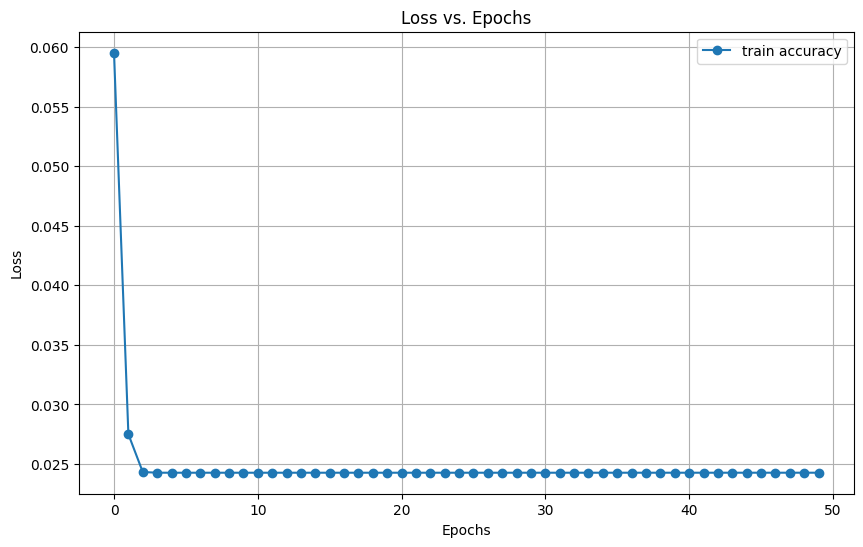

In [81]:
# plot the train and test accuracies
plt.figure(figsize=(10, 6)) 
plt.plot(range(EPOCHS), train_losses, marker='o', linestyle='-',label='train accuracy')
# plt.plot(range(EPOCHS), test_accuracies, marker='s', linestyle='--', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
y_test_pred = predict(neural_net, x_test)
print(np.mean(np.square(x_test[0] - y_test_pred[0])))

0.023586807248868635


In [83]:
print(y_test[0][0:10])
print(y_test_pred[0][0:10])

[0.34970105 0.59997979 0.21526022 0.68059822 0.37701691 0.41246322
 0.39346894 0.47713774 0.59459719 0.32965389]
[0.4803234  0.53446226 0.44948834 0.52207083 0.474082   0.44022412
 0.45942802 0.49407908 0.47714493 0.52060666]


In [84]:
tf_neural_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_size)),
    tf.keras.layers.Dense(units=50, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=3, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=50, activation="relu"),
    tf.keras.layers.Dense(units=output_size, activation="sigmoid"),
])

tf_neural_net.compile(optimizer="sgd", loss="mse")

tf_neural_net.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 50)                51250     
                                                                 
 dense_36 (Dense)            (None, 10)                510       
                                                                 
 dense_37 (Dense)            (None, 3)                 33        
                                                                 
 dense_38 (Dense)            (None, 5)                 20        
                                                                 
 dense_39 (Dense)            (None, 10)                60        
                                                                 
 dense_40 (Dense)            (None, 50)                550       
                                                                 
 dense_41 (Dense)            (None, 1024)             

In [85]:
history = tf_neural_net.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0258
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0258
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 8/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0258
Epoch 9/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 10/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 11/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0258
Epoch 12/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0258
Epoch 13/50
32/32 [============================

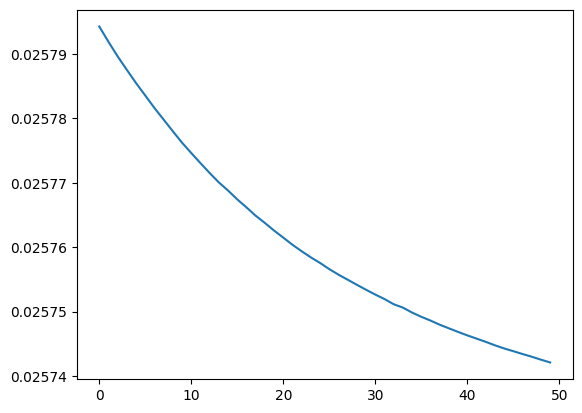

In [86]:
plt.figure()
plt.plot(history.history["loss"])

In [87]:
y_test_pred_tf = tf_neural_net.predict(x_test)
mse = tf.keras.losses.MeanSquaredError()

# print(np.linalg.norm(x_test[0] - y_test_pred_tf[0]))
print(np.mean(np.square(y_test[0] - y_test_pred_tf[0])))
print(mse(tf.expand_dims(y_test[0], axis=1), tf.expand_dims(y_test_pred_tf[0], axis=1)))

1/1 [==============================] - 0s 182ms/step
0.02499563866952986
tf.Tensor(0.02499564, shape=(), dtype=float32)


In [88]:
print(y_test[0][0:10])
print(y_test_pred_tf[0][0:10])

[0.34970105 0.59997979 0.21526022 0.68059822 0.37701691 0.41246322
 0.39346894 0.47713774 0.59459719 0.32965389]
[0.5006545  0.5003246  0.49996835 0.50117505 0.49621066 0.5019879
 0.5038689  0.49788952 0.49678692 0.49495965]


In [115]:
random_input = np.random.multivariate_normal(mean=np.zeros(shape=(input_size,)) + 5, cov=np.eye(input_size), size=1)

random_input = (random_input - min_vals) / (max_vals - min_vals)

pred1 = predict(neural_net, random_input)
pred2 = tf_neural_net.predict(random_input)


print("reconstruction error", np.mean(np.square(random_input - pred1)))
print("reconstruction error (tf)", np.mean(np.square(random_input - pred2)))

1/1 [==============================] - 0s 24ms/step
reconstruction error 0.6344493840036094
reconstruction error (tf) 0.6337579082104376
